In [25]:
import pandas as pd
import numpy as np
import scipy
import matplotlib.pyplot as plt
import networkx as nx
from ts2vg import NaturalVG, HorizontalVG

# Algoritmo de Visibilidad

Se dice que dos valores $(t_a, y_a)$ y $(t_b, y_b)$ tienen "visibilidad" si, cualquier valor $(t_c, y_c)$ que esté colocado entre ambos, cumple que:

$$
y_c < y_b + (y_a - y_b) \frac{t_b - t_c}{t_b - t_a}
$$

Si cumplen esta condición, entonces se añadirá una arista entre $(t_a, y_a)$ y $(t_b, y_b)$.

A continuación definiremos una función "visibilidad(ts)" que reciba una serie ts y genere una gráfica de Networkx donde sus aristas cumplen la condición anterior:

**Desarrollo del criterio de visibilidad:**

Sea $m=\frac{y_a - y_b}{t_a - t_b}$ la pendiente entre $(t_a,y_a)$ y $(t_b,y_b)$. Consideremos la ecuación de la recta punto pendiente con $(t_b,y_b)$:

$y-y_b = m(t-t_b) → y-y_b = \frac{y_a - y_b}{t_a - t_b}(t-t_b)$

Lo evaluamos en los puntos intermedios ($t=t_c$, $y=y_c$) | $a<c<b$:

$y_c = y_b + \frac{y_a - y_b}{t_a - t_b}(t_c-t_b)$

Como $t_c-t_b = -(t_b-t_c)$ y $t_a-t_b = -(t_b-t_a)$, sustituimos ambos signos:

$y_c = y_b + \frac{y_a - y_b}{-(t_b-t_a)}(- (t_b-t_c)) = y_b + \frac{y_a - y_b}{t_b-t_a}(t_b-t_c)$

El punto $c$ estará por debajo de la recta que une $a$ y $b$ si se cumple:

$$
y_c < y_b + (y_a - y_b)\frac{t_b - t_c}{t_b - t_a}
$$


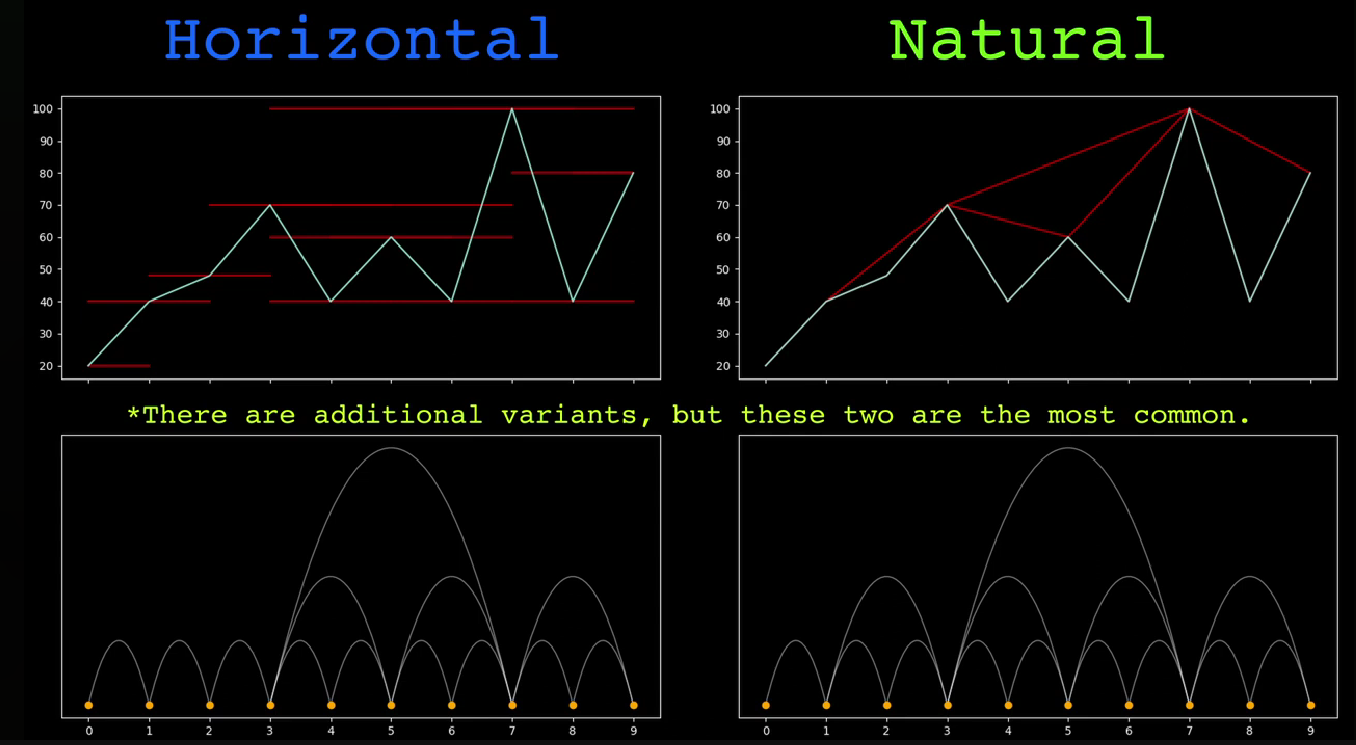

In [35]:
def visibilidad(ts):
    """
    Construye la gráfica de visibilidad de una serie dada.
    Parámetros:
    ts : lista de float; Serie ts = [x_0, x_1, ..., x_(n-1)].
    Regresa:
    G  : gráfica de Networkx.
    """
    n = len(ts)  # Longitud de la serie de tiempo
    G = nx.Graph()  # Crea una gráfica vacía

    for i in range(1, n+1):
        G.add_node(i, value=ts[i-1]) # Agrega los nodos a la gráfica

    # Checa cada pareja (i, j)
    for i in range(1, n+1):
        for j in range(i+1, n+1):
            xi, xj = ts[i-1], ts[j-1]
            visible = True
            # Checa que los puntos intermedios cumplan la condición de visibilidad
            for k in range(i+1, j):
                xk = ts[k-1]
                recta_k = xi + (xj - xi) * (k - i) / (j - i)
                if xk >= recta_k:
                    visible = False
                    break
            if visible:
                G.add_edge(i, j) # Añade las aristas que sean visibles

    return G

In [65]:
def plot_visibilidad(G, ts):
    """
    Grafica la serie de tiempo y su grafo de visibilidad.
    Parámetros:
        G  : networkx.Graph generado por visibilidad(ts)
        ts : lista o array de la serie de tiempo original
    """
    fig, axes = plt.subplots(1, 2, figsize=(12, 4))

    axes[0].plot(range(1, len(ts)+1), ts, marker='o', color='#a2ca8e')
    axes[0].set_title("Serie de tiempo")
    axes[0].set_xlabel("Tiempo (t)")
    axes[0].set_ylabel("Valor (y)")
    axes[0].grid(True, linestyle='--', alpha=0.5)

    #Posicion de nodos
    pos = {i: (i, ts[i-1]) for i in G.nodes()}
    nx.draw(
        G, pos, ax=axes[1],
        with_labels=True, node_color='#66af91', node_size=100,
        font_size=8, edge_color='#e6626f'
    )
    axes[1].set_title("Grafo de Visibilidad")
    axes[1].set_xlabel("Tiempo (t)")
    axes[1].set_ylabel("Valor (y)")

    plt.tight_layout()
    plt.show()

# Serie de tiempo simple

In [5]:
time_series = [20,40,48,70,40,60,40,100,40,80]

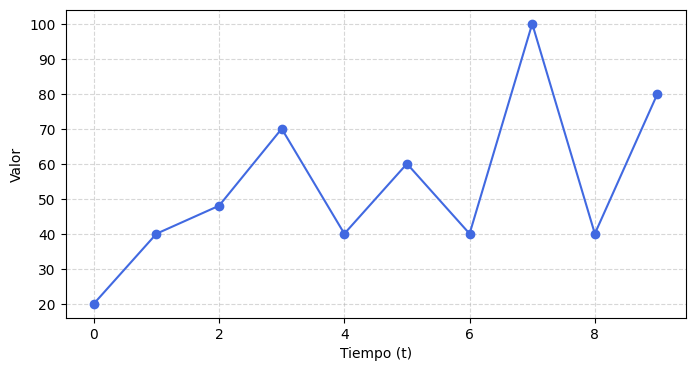

In [11]:
plt.figure(figsize=(8, 4))
plt.plot(time_series, marker='o', linestyle='-', color='royalblue')
plt.xlabel("Tiempo (t)")
plt.ylabel("Valor")
plt.grid(True, linestyle="--", alpha=0.5)
plt.show()

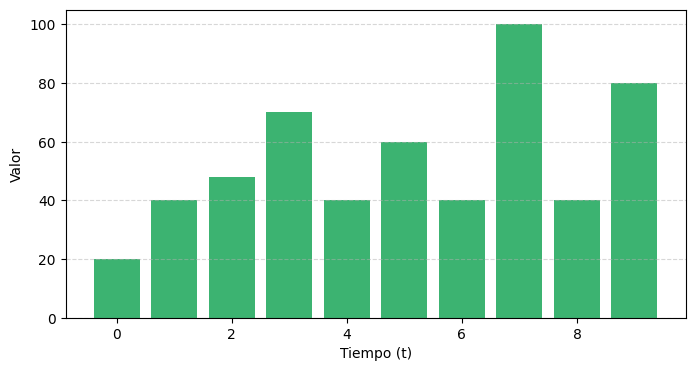

In [12]:
plt.figure(figsize=(8, 4))
plt.bar(range(len(time_series)), time_series, color='mediumseagreen')
plt.xlabel("Tiempo (t)")
plt.ylabel("Valor")
plt.grid(axis="y", linestyle="--", alpha=0.5)
plt.show()

In [39]:
print(visibilidad(time_series).nodes())
print(visibilidad(time_series).edges)

[1, 2, 3, 4, 5, 6, 7, 8, 9, 10]
[(1, 2), (2, 3), (2, 4), (3, 4), (4, 5), (4, 6), (4, 8), (5, 6), (6, 7), (6, 8), (7, 8), (8, 9), (8, 10), (9, 10)]


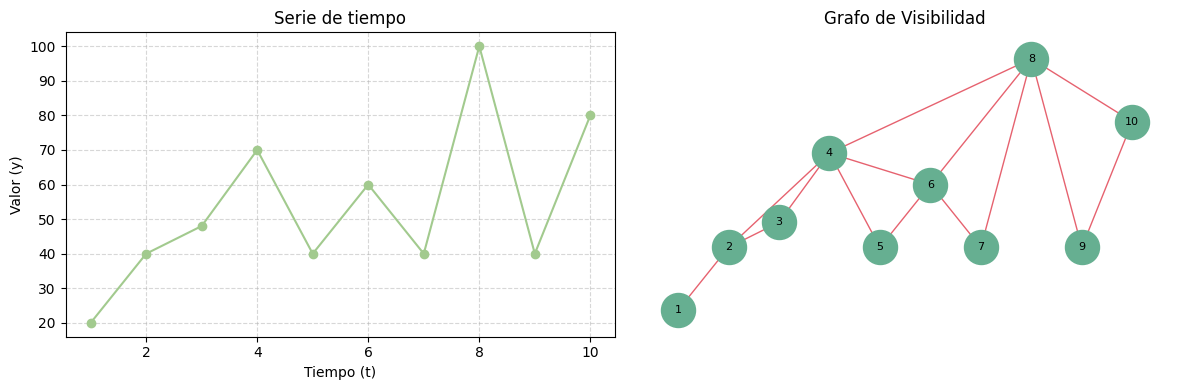

In [60]:
G_simple = visibilidad(time_series)
plot_visibilidad(G_simple, time_series)

# Serie de Conway

Sea $b(k)$ definida por:

$b(k) = a(k) - \frac{k}{2}, \quad k = 1, 2, \dots, n,$

donde la sucesión $a(k)$ satisface:

\begin{cases}
a(1) = 1, \\
a(2) = 1, \\
a(k) = a(a(k-1)) + a(k - a(k-1)), & k > 2.
\end{cases}

$a(3) = a(a(3-1) + a(3-a(3-1)))$

$= a(a(2) + a(3-a(2)))$

$= a((1) + a(2))$

$= a(1 + 1)$
$= 1$

In [45]:
def conway(n):
    """
    Calcula los primeros n términos b(k) = a(k) - k/2 con k=1..n,
    donde a(k) satisface:
        a(1) = 1, a(2) = 1,
        a(k) = a(a(k-1)) + a(k - a(k-1)), k > 2.
    Parámetros:
    n  :  int; Número de iteraciones.
    Regresa:
    b  :  lista de float; [b(1), ..., b(n)].
    """
    if n < 1:
        return [] # Si n<1, regresamos una lista vacía, pues a(n) no está definido

    a = [0] * (n+1) # Crea una lista de longitud n+1

    a[1] = 1  # a(1)=1

    if n >= 2:
        a[2] = 1 # a(2)=1, sólo si se hace más de una iteración

    for i in range(3, n+1):
        a[i] = a[a[i-1]] + a[i - a[i-1]] #a(a(k-1)) + a(k - a(k-1)) para k > 2

    b = [(a[k] - k/2) for k in range(1, n+1)] # Calcula b(k) = a(k) - k/2 para cada k
    return b

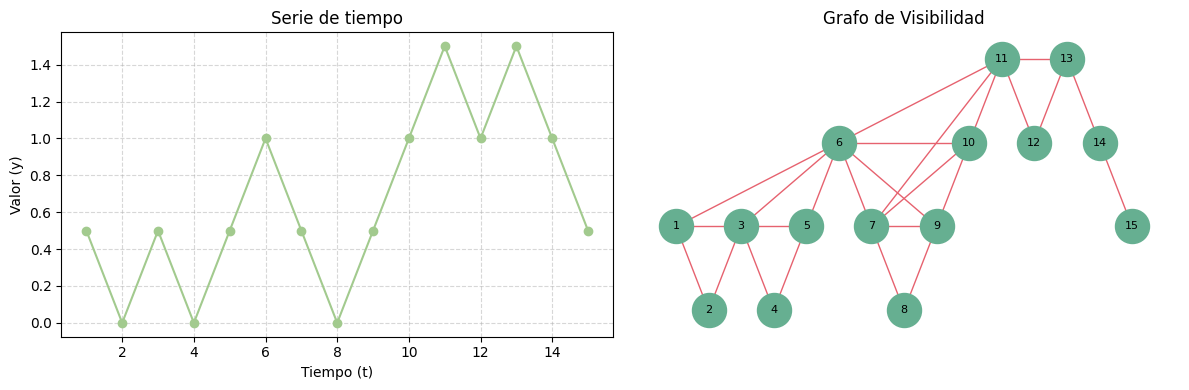

Serie de Conway con n=15
El orden de la gráfica es 15
El tamaño de la gráfica es: 25
--------------------------------------------------


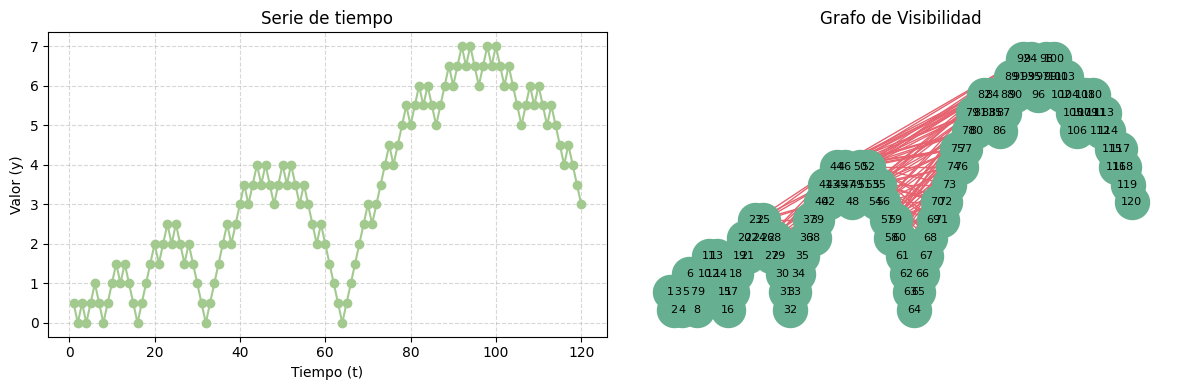

Serie de Conway con n=120
El orden de la gráfica es 120
El tamaño de la gráfica es: 359
--------------------------------------------------


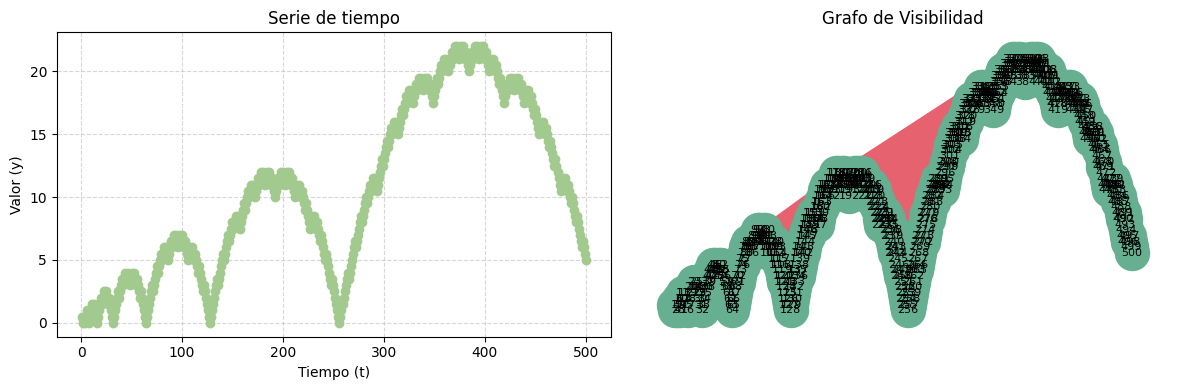

Serie de Conway con n=500
El orden de la gráfica es 500
El tamaño de la gráfica es: 2486
--------------------------------------------------


In [61]:
for n, ns in [(15, 300), (120, 100), (500, 10)]:
    ts = conway(n)
    G_conway = visibilidad(ts)
    plot_visibilidad(G_conway, ts)

    print(f"Serie de Conway con n={n}")
    print("El orden de la gráfica es", G_conway.order())
    print("El tamaño de la gráfica es:", G_conway.size())
    print("-"*50)

# Movimiento Browniano

### Proceso Estocástico

Un **proceso estocástico** es una colección de **variables aleatorias** indexadas por un parámetro, generalmente el tiempo:

$\{ X_t : t \in T \}$ en donde:

- $t \in T$ es el índice (discreto: $t = 0,1,2,\dots$ o continuo: $t \ge 0$).  
- Cada $X_t$ es una **variable aleatoria** que puede tomar distintos valores.  

En otras palabras, un proceso estocástico describe cómo **una cantidad aleatoria evoluciona en el tiempo**, y cada realización del proceso puede generar una trayectoria diferente.

El **movimiento Browniano** (también llamado proceso de Wiener) es un proceso estocástico continuo que describe trayectorias aleatorias en el tiempo.

**Originalmente** se observó en partículas de polen flotando en agua, que se movían de forma aparentemente aleatoria.

En matemáticas y finanzas se usa para **modelar caminatas aleatorias continuas:**, como precios de acciones o difusión de partículas.

Un movimiento Browniano B(t) cumple:

1. B(0) = 0  
2. **Incrementos independientes**: Para tiempos $0 \leq s < t$, los incrementos
   $B(t) - B(s)$ son independientes de la historia hasta el tiempo s.  
3. **Incrementos normales**:
   $B(t) - B(s) \sim N(0, t-s)$ es decir, siguen una distribución normal con media cero y varianza igual al intervalo de tiempo \(t-s\).  
4. **Trayectorias continuas pero no diferenciables**: el camino es suave (sin saltos), pero irregular (no tiene derivada definida en ningún punto).

Algunas aplicaciones:

1. Finanzas: modelar precios de acciones y derivados (p.ej., Black-Scholes).  
2. Física: difusión de partículas o moléculas.  
3. Biología: movimiento de moléculas en soluciones.  
4. Matemáticas y estadística: teoría de procesos estocásticos y análisis de ruido.

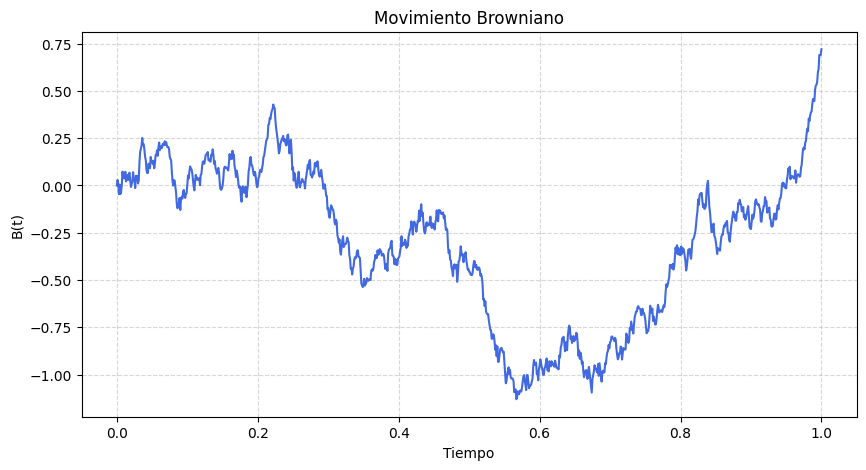

In [69]:
#Parámetros
T = 1.0      #tiempo
n = 1000     #num pasos
dt = T/n     #tamaño del paso
B0 = 0       #valor inicial

#Generar incrementos normales
dB = np.random.normal(loc=0.0, scale=np.sqrt(dt), size=n)

#Construir la serie de tiempo (suma acumulativa)
B = np.cumsum(dB)
B = np.insert(B, 0, B0)  # agregar B0 al inicio

t = np.linspace(0, T, n+1)

# Graficar
plt.figure(figsize=(10,5))
plt.plot(t, B, color='royalblue')
plt.title("Movimiento Browniano")
plt.xlabel("Tiempo")
plt.ylabel("B(t)")
plt.grid(True, linestyle='--', alpha=0.5)
plt.show()

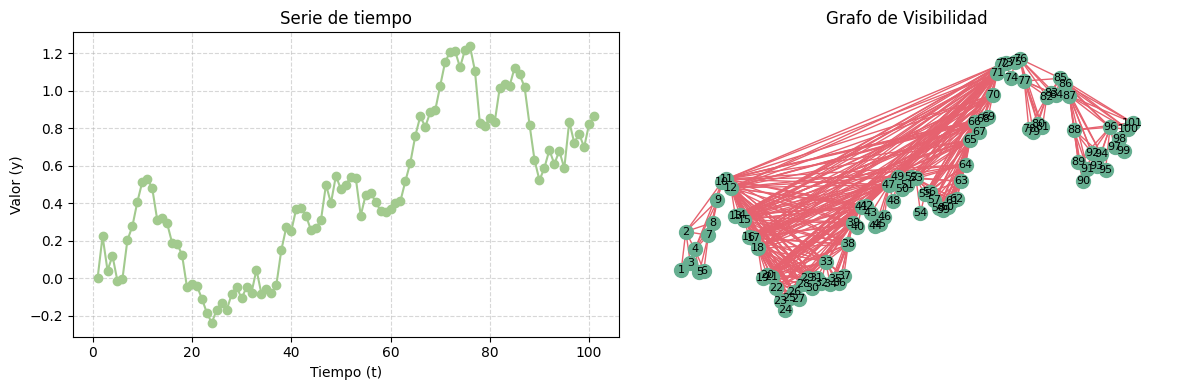

In [66]:
G_browniano = visibilidad(B)
plot_visibilidad(G_browniano, B)

# Comparar las propiedades de las series de tiempo

In [64]:
grafos = {
    "Simple": G_simple,
    "Conway": G_conway,
    "Browniano": G_browniano
}

for nombre, G in grafos.items():
    orden = G.order()
    tamaño = G.size()
    densidad = round(nx.density(G), 2)
    grado_prom = round(sum(dict(G.degree()).values()) / orden, 2)
    clustering_prom = round(nx.average_clustering(G), 2)
    longitud_camino = round(nx.average_shortest_path_length(G), 2)

    print(f"--- {nombre} ---")
    print(f"Orden (nodos): {orden}")
    print(f"Tamaño (aristas): {tamaño}")
    print(f"Densidad: {densidad}")
    print(f"Grado promedio: {grado_prom}")
    print(f"Coeficiente de clustering promedio: {clustering_prom}")
    print(f"Longitud promedio del camino: {longitud_camino}\n")

--- Simple ---
Orden (nodos): 10
Tamaño (aristas): 14
Densidad: 0.31
Grado promedio: 2.8
Coeficiente de clustering promedio: 0.64
Longitud promedio del camino: 2.07

--- Conway ---
Orden (nodos): 500
Tamaño (aristas): 2486
Densidad: 0.02
Grado promedio: 9.94
Coeficiente de clustering promedio: 0.61
Longitud promedio del camino: 8.16

--- Browniano ---
Orden (nodos): 101
Tamaño (aristas): 478
Densidad: 0.09
Grado promedio: 9.47
Coeficiente de clustering promedio: 0.7
Longitud promedio del camino: 3.6

